In [19]:
#pip install turicreate
pip install -U turicreate

Requirement already up-to-date: turicreate in /usr/local/lib/python3.6/dist-packages (6.2)


In [0]:
import pandas as pd # pandas is a data manipulation library
import numpy as np #provides numerical arrays and functions to manipulate the arrays efficiently
import random
import matplotlib.pyplot as plt # data visualization library
import operator
from os import path
import turicreate as tc
from datetime import datetime

Load dataset to memory:

In [21]:
m_cols = ['user_id','item_id','rating','timestamp']
df = pd.read_csv('u1.base', delimiter='\t', names=m_cols, encoding='latin-1')
print(df.shape)
print(df.head())
# Add movies names

item_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url'
          ,'unknown','Action','Adventure','Animation','Childrens','Comedy',
          'Crime','Documentary','Drama','Fantasy','Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi',
        'Thriller','War','Western']
items = pd.read_csv('u.item', delimiter='|', encoding='latin-1', names=item_cols)
new_columns = items.columns.values
new_columns[0] = 'item_id'
new_columns[1] = "item_name"
items.columns = new_columns
df = pd.merge(df, items[["item_id", "item_name"]], on='item_id', how='inner')
print(df.shape)
print(df.head())
# Add user gender

users = pd.read_csv('u.user', delimiter='|', encoding='latin-1')
new_columns = users.columns.values
new_columns[0] = 'user_id'
new_columns[2] = "gender"
users.columns = new_columns
df = pd.merge(df, users[["user_id", "gender"]], on='user_id', how='inner')
print(df.shape)

print(df.head())

(80000, 4)
   user_id  item_id  rating  timestamp
0        1        1       5  874965758
1        1        2       3  876893171
2        1        3       4  878542960
3        1        4       3  876893119
4        1        5       3  889751712
(80000, 5)
   user_id  item_id  rating  timestamp         item_name
0        1        1       5  874965758  Toy Story (1995)
1        2        1       4  888550871  Toy Story (1995)
2        6        1       4  883599478  Toy Story (1995)
3       13        1       3  882140487  Toy Story (1995)
4       16        1       5  877717833  Toy Story (1995)
(79865, 6)
   user_id  item_id  ...                            item_name  gender
0        2        1  ...                     Toy Story (1995)       F
1        2       25  ...                 Birdcage, The (1996)       F
2        2      111  ...  Truth About Cats & Dogs, The (1996)       F
3        2      127  ...                Godfather, The (1972)       F
4        2      237  ...                 

# New Section

Ex 1.a.

   item_id    rating          item_name
0        1  3.890052   Toy Story (1995)
1        2  3.182692   GoldenEye (1995)
2        3  2.986486  Four Rooms (1995)
3        4  3.529412  Get Shorty (1995)
4        5  3.308824     Copycat (1995)


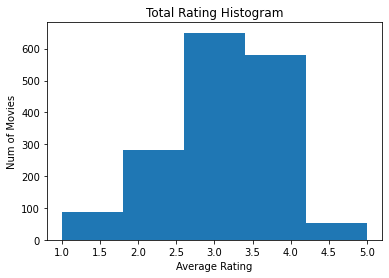

Three highest ranking movies:
       rating                                          item_name
1193     5.0         Marlene Dietrich: Shadow and Light (1996) 
1284     5.0                                    Star Kid (1997)
1620     5.0  Entertaining Angels: The Dorothy Day Story (1996)


In [22]:
dftmp = df[['item_id', 'item_name', 'rating']].groupby('item_id', as_index=False).agg({'rating':
                                  np.mean, 'item_name': lambda x: x.iloc[0]})

print(dftmp.head())

plt.hist(dftmp['rating'], bins=5)
plt.title('Total Rating Histogram')
plt.xlabel('Average Rating')
plt.ylabel('Num of Movies')
plt.show()

print("Three highest ranking movies:\n", dftmp[['rating', 'item_name']].sort_values(by=['rating'], ascending=False).head(3))

Ex 1.b.

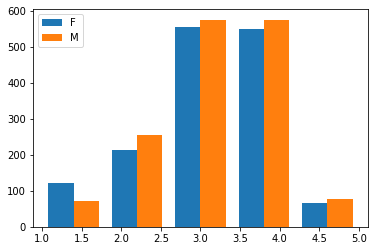

Three highest ranking movies for Males:
       item_id gender  rating           item_name
2326     1189      M     5.0  Prefontaine (1997)
2299     1175      M     5.0    Hugo Pool (1997)
2521     1293      M     5.0     Star Kid (1997)

Three highest ranking movies for Females:
       item_id gender  rating           item_name
2325     1189      F     5.0  Prefontaine (1997)
2379     1218      F     5.0       Friday (1995)
2535     1301      F     5.0      Stripes (1981)

 count    1411.000000
mean        0.531291
std         0.579893
min         0.000000
25%         0.150000
50%         0.333333
75%         0.704293
max         4.000000
Name: delta, dtype: float64

     item_id                                          item_name  delta
0       314        3 Ninjas: High Noon At Mega Mountain (1998)    0.0
1       320  Paradise Lost: The Child Murders at Robin Hood...    0.0
2       374     Mighty Morphin Power Rangers: The Movie (1995)    0.0
3       437            Amityville 1992: It'

In [23]:
dftmp = df[['item_id','gender', 'item_name', 'rating']].groupby(['item_id', 'gender'], as_index=False).agg({'rating':
                                  np.mean, 'item_name': lambda x: x.iloc[0]})

# Plot rating histogram by gender
dftmp = dftmp.sort_values(by='rating')
genders = dftmp['gender'].unique()
plt.hist([dftmp.loc[dftmp.gender == x, 'rating'] for x in genders], bins=5)
plt.gca().legend(tuple(genders), loc='upper left')
plt.show()

# List top 3 ranking movies for males and females
print("Three highest ranking movies for Males:\n", dftmp.loc[dftmp['gender'] == 'M'].sort_values(by=['rating'], ascending=False).head(3))
print("\nThree highest ranking movies for Females:\n", dftmp.loc[dftmp['gender'] == 'F'].sort_values(by=['rating'], ascending=False).head(3))

# Create new dataframe to hold the difference in rating between genders
ratings_by_gender = df.pivot_table('rating',index=['item_id'], columns='gender', aggfunc='mean')
ratings_by_gender['delta'] = (abs(ratings_by_gender.F - ratings_by_gender.M))
ratings_by_gender = ratings_by_gender.dropna()

# Print out the rating difference basic statistics
print("\n", ratings_by_gender['delta'].describe())

genre_cols = ['unknown','Action','Adventure','Animation','Childrens','Comedy',
          'Crime','Documentary','Drama','Fantasy','Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi',
        'Thriller','War','Western']

# Find similarly rated movies for both genders
similar_movie_ratings_by_gender = ratings_by_gender.loc[ratings_by_gender['delta'] == 0]
similar_movie_ratings_by_gender = pd.merge(similar_movie_ratings_by_gender, items, on='item_id', how='inner')

# Print similarly rated movies details
print("\n", similar_movie_ratings_by_gender[["item_id", "item_name", 'delta']])
for col in genre_cols:
  print(similar_movie_ratings_by_gender[col].value_counts())

# Find differently rated movies for both genders (Defined as: rating_delta >= 2)
different_movie_ratings_by_gender = ratings_by_gender.loc[ratings_by_gender['delta'] >= 2].sort_values(by='delta', ascending=False)
different_movie_ratings_by_gender = pd.merge(different_movie_ratings_by_gender, items, on='item_id', how='inner')

# Print similarly rated movies details
print("\n", different_movie_ratings_by_gender[["item_id", "item_name", 'delta']])
for col in genre_cols:
  print(different_movie_ratings_by_gender[col].value_counts())





Ex 1.c.

In [0]:
def bars_plotter(x, y, title=""):
  fig = plt.figure(1, figsize=(18,13))
  ax = fig.add_subplot(2,1,2)
  ax.bar(x, y, align='center', color='b')

  plt.xticks(rotation=315, fontsize = 15)
  plt.yticks(fontsize = 20)
  plt.ylabel("# Occurences", fontsize = 25)
  plt.title(title, bbox={'facecolor':'k', 'pad':5},color='w',fontsize = 30)
  plt.show()


General population:

Top rated by the general population:

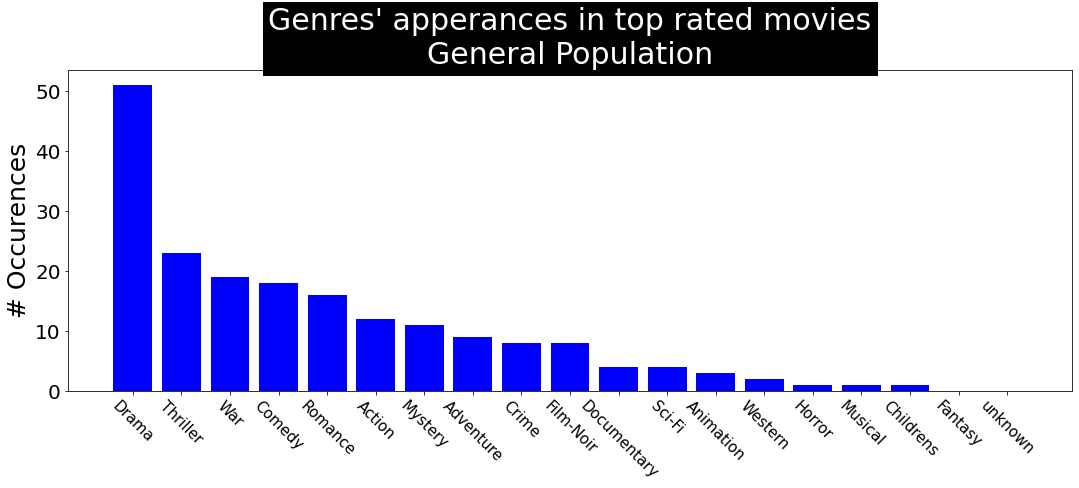

In [25]:
gen_pop_mean = df[['item_id', 'rating']].groupby('item_id', as_index=False).agg({'rating':
                                  np.mean})
dftmp = pd.merge(ratings_by_gender, items, on='item_id', how='inner')
dftmp = pd.merge(dftmp, gen_pop_mean, on='item_id', how='inner')

top_100 = dftmp[['rating', 'item_id'] + genre_cols].sort_values(by=['rating'], ascending=False).head(100).loc[:, 'unknown':].sum().sort_values(ascending=False)

x = top_100.index.tolist()
y = top_100.tolist()
plot_title = "Genres' apperances in top rated movies\nGeneral Population"

bars_plotter(x, y, plot_title)

Least rated by the general population:

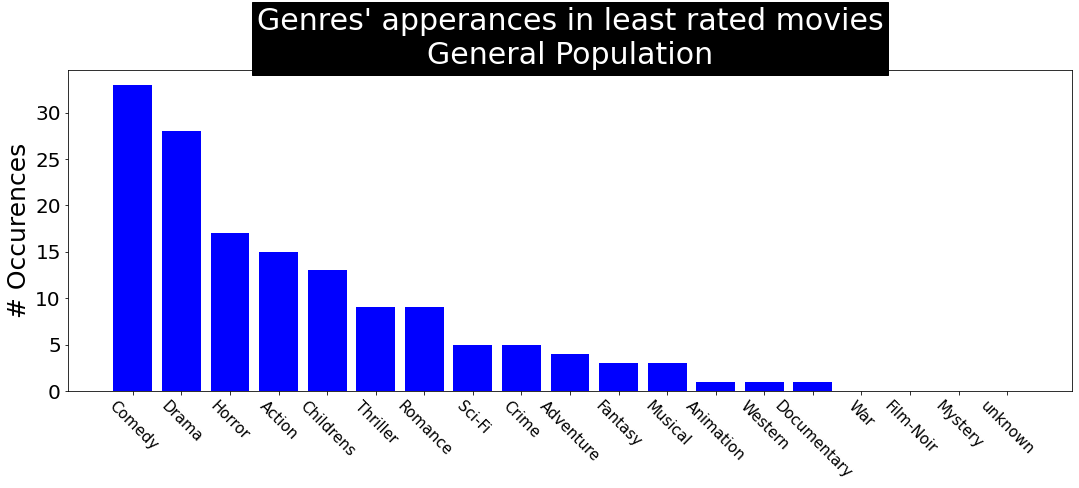

In [26]:
least_100 = dftmp[['rating', 'item_id'] + genre_cols].sort_values(by=['rating'], ascending=True).head(100).loc[:, 'unknown':].sum().sort_values(ascending=False)

x = least_100.index.tolist()
y = least_100.tolist()
plot_title = "Genres' apperances in least rated movies\nGeneral Population"

bars_plotter(x, y, plot_title)

Top rated by males:

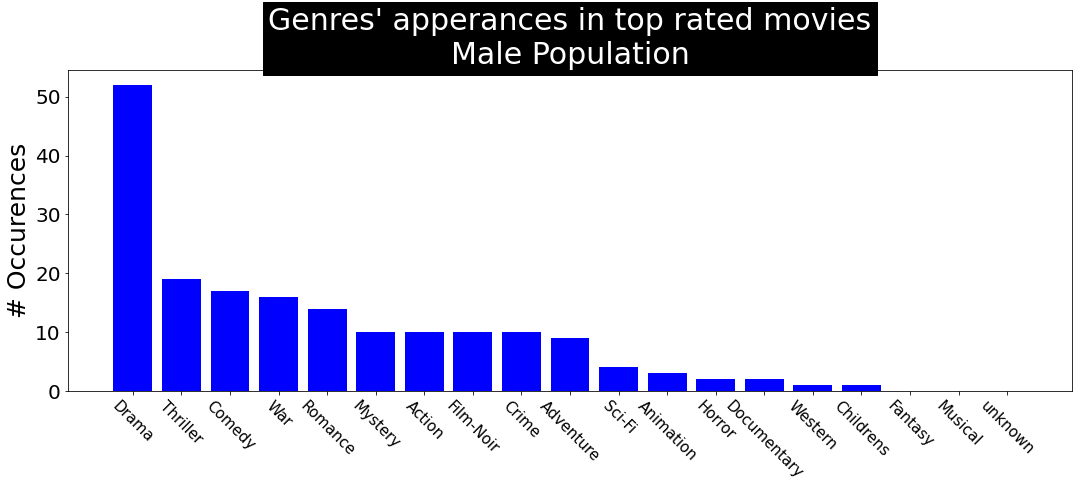

In [27]:
top_100_male = dftmp[['M', 'item_id'] + genre_cols].sort_values(by=['M'], ascending=False).head(100).loc[:, 'unknown':].sum().sort_values(ascending=False)

x = top_100_male.index.tolist()
y = top_100_male.tolist()
plot_title = "Genres' apperances in top rated movies\nMale Population"

bars_plotter(x, y, plot_title)

Least rated by males:

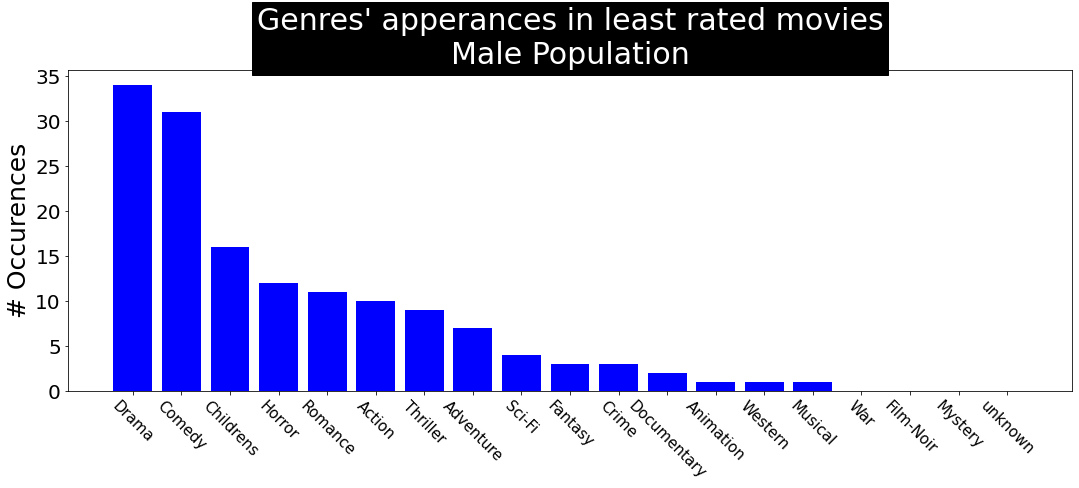

In [28]:
least_100_male = dftmp[['M', 'item_id'] + genre_cols].sort_values(by=['M'], ascending=True).head(100).loc[:, 'unknown':].sum().sort_values(ascending=False)

x = least_100_male.index.tolist()
y = least_100_male.tolist()
plot_title = "Genres' apperances in least rated movies\nMale Population"

bars_plotter(x, y, plot_title)

Females:

Top rated by females:

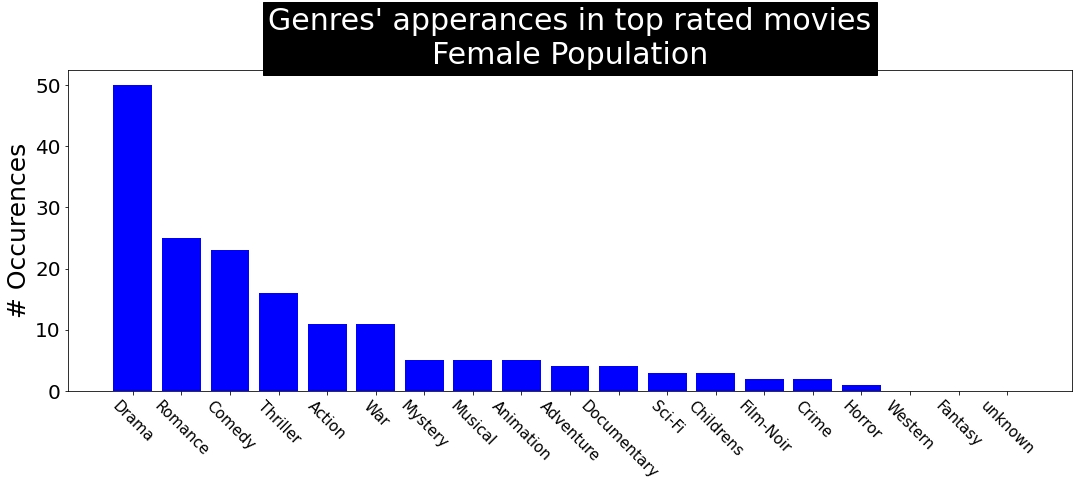

In [29]:
top_100_female = dftmp[['F', 'item_id'] + genre_cols].sort_values(by=['F'], ascending=False).head(100).loc[:, 'unknown':].sum().sort_values(ascending=False)

x = top_100_female.index.tolist()
y = top_100_female.tolist()
plot_title = "Genres' apperances in top rated movies\nFemale Population"

bars_plotter(x, y, plot_title)

Least rated by females:

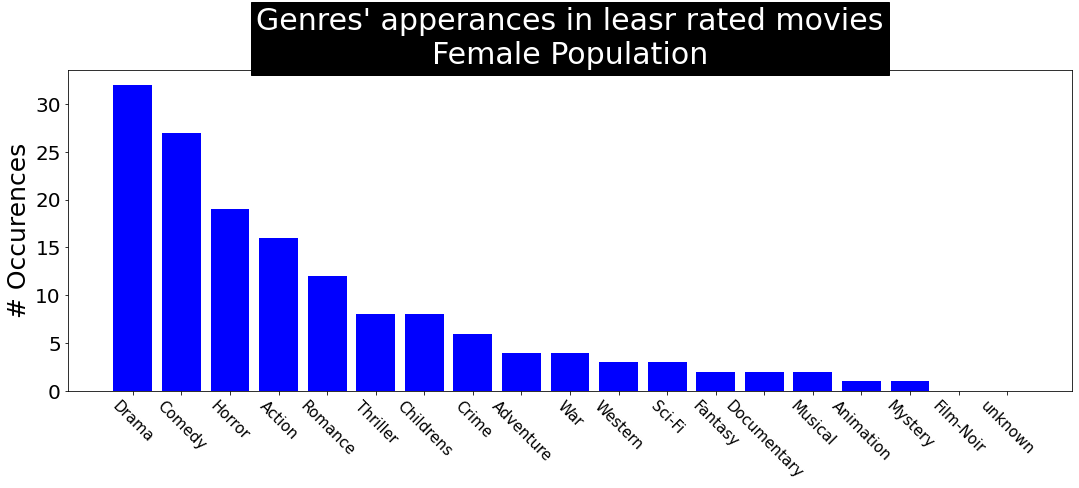

In [30]:
least_100_female = dftmp[['F', 'item_id'] + genre_cols].sort_values(by=['F'], ascending=True).head(100).loc[:, 'unknown':].sum().sort_values(ascending=False)

x = least_100_female.index.tolist()
y = least_100_female.tolist()
plot_title = "Genres' apperances in leasr rated movies\nFemale Population"

bars_plotter(x, y, plot_title)

Ex 1.d.

In [31]:
total_num_of_users = len(df['user_id'].unique())
highest_possible_ranking = 5

gen_pop_count = df[['item_id','item_name', 'rating']].groupby('item_id', as_index=False).agg({'rating':
                                  'count', 'item_name': lambda x: x.iloc[0]})
gen_pop_count.columns = ['item_id', 'rating_count', 'item_name']
dftmp = pd.merge(gen_pop_count, gen_pop_mean, on='item_id', how='inner')

dftmp['calculated_popularity'] = ((dftmp.rating * dftmp.rating_count)/(highest_possible_ranking * total_num_of_users))
dftmp = dftmp.sort_values(by=['calculated_popularity'], ascending=False)

print(dftmp[['item_name', 'rating', 'calculated_popularity']].head(10))

                          item_name    rating  calculated_popularity
49                 Star Wars (1977)  4.358178               0.446921
180       Return of the Jedi (1983)  4.009501               0.358386
99                     Fargo (1996)  4.108861               0.344586
257                  Contact (1997)  3.823383               0.326327
0                  Toy Story (1995)  3.890052               0.315499
173  Raiders of the Lost Ark (1981)  4.247093               0.310191
126           Godfather, The (1972)  4.256637               0.306369
285     English Patient, The (1996)  3.641753               0.300000
287                   Scream (1996)  3.445013               0.285987
299            Air Force One (1997)  3.656250               0.273248


# Ex 3

Ex 3.a.

In [32]:
# Load interaction data
m_cols = ['user_id','item_id','rating','timestamp']
df_train = pd.read_csv('u1.base', delimiter='\t', names=m_cols, encoding='latin-1')
df_test = pd.read_csv('u1.test', delimiter='\t', names=m_cols, encoding='latin-1')
print(df_train.shape)
print(df_train.head())

# Add movies names
item_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url'
          ,'unknown','Action','Adventure','Animation','Childrens','Comedy',
          'Crime','Documentary','Drama','Fantasy','Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi',
        'Thriller','War','Western']
items = pd.read_csv('u.item', delimiter='|', encoding='latin-1', names=item_cols)
new_columns = items.columns.values
new_columns[0] = 'item_id'
new_columns[1] = "item_name"
items.columns = new_columns
df_train = pd.merge(df_train, items, on='item_id', how='inner')
df_test = pd.merge(df_test, items, on='item_id', how='inner')
print(df_train.shape)
print(df_train.head())

(80000, 4)
   user_id  item_id  rating  timestamp
0        1        1       5  874965758
1        1        2       3  876893171
2        1        3       4  878542960
3        1        4       3  876893119
4        1        5       3  889751712
(80000, 27)
   user_id  item_id  rating  timestamp  ... Sci-Fi Thriller  War Western
0        1        1       5  874965758  ...      0        0    0       0
1        2        1       4  888550871  ...      0        0    0       0
2        6        1       4  883599478  ...      0        0    0       0
3       13        1       3  882140487  ...      0        0    0       0
4       16        1       5  877717833  ...      0        0    0       0

[5 rows x 27 columns]


In [0]:
def predict_on_test(model, test_data):
  sf = tc.SFrame({"user_id": test_data['user_id'], "item_id": test_data['item_id']})
  test_data['predicted_rating'] = model[1].predict(sf)
  MAE = np.sum(abs(test_data['rating']-test_data['predicted_rating']))/test_data.shape[0]
  print("MAE - model", model[0], MAE)

In [48]:
models = []
# Matrix Factorization
sf = tc.SFrame({"user_id":df_train['user_id'],
                                     "item_id":df_train['item_id'],
                                     "rating":df_train['rating']
                                     })
models.append(("Matrix Factorization", tc.recommender.factorization_recommender.create(sf, target='rating')))

# Item Similarity
# models.append(("Item Similarity", tc.recommender.item_similarity_recommender.create(sf, target='rating')))
models.append(("Item Similarity", tc.recommender.item_similarity_recommender.create(sf, target='rating')))

# Item Content
item_content_sf = tc.SFrame({"item_id": df_train['item_id'], "item_data": df_train[genre_cols]})
models.append(("Item Content", tc.recommender.item_content_recommender.create(item_data=item_content_sf, item_id='item_id',user_id='user_id', observation_data=sf, target='rating')))

for model in models:
  predict_on_test(model, df_test)


Preparing data set.

Data has 80000 observations with 943 users and 1650 items.

Data prepared in: 0.071721s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 80000 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 0.68819                                  |

| 5       | 0.0488281         | 0.715577                                 |

| 6       | 0.0244141         | 0.767495                                 |

| 7       | 0.012207          | 0.840823                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 0.68819                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 87us         | 1.25115           | 1.11855               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 36.64ms      | 1.06979           | 1.0343                | 0.0976562   |

| 2       | 66.289ms     | 0.927117          | 0.962865              | 0.0580668   |

| 3       | 90.666ms     | 0.82748           | 0.909652              | 0.042841    |

| 4       | 114.786ms    | 0.747192          | 0.864393              | 0.0345267   |

| 5       | 154.683ms    | 0.689968          | 0.83063               | 0.029206    |

| 10      | 281.547ms    | 0.580168          | 0.761667              | 0.017366    |

| 50      | 1.26s        | 0.490142          | 0.700066              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.465458

Final training RMSE: 0.682208

Preparing data set.

Data has 80000 observations with 943 users and 1650 items.

Data prepared in: 0.076088s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 11.518ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 14.765ms                            | 0                | 2               |

| 163.785ms                           | 100              | 1650            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.1823s

Applying transform:
Class             : AutoVectorizer

Model Fields
------------
Features          : ['item_data']
Excluded Features : ['item_id']

Column     Type  Interpretation  Transforms  Output Type
---------  ----  --------------  ----------  -----------
item_data  str   categorical     None        str        




Starting brute force nearest neighbors model training.

Validating distance components.

Initializing model data.

Initializing distances.

Done.

Starting pairwise querying.

+--------------+---------+-------------+--------------+

| Query points | # Pairs | % Complete. | Elapsed Time |

+--------------+---------+-------------+--------------+

| 1            | 19      | 5.26316     | 149us        |

| Done         |         | 100         | 503us        |

+--------------+---------+-------------+--------------+

Preparing data set.

Data has 80000 observations with 943 users and 1650 items.

Data prepared in: 0.088003s

Loading user-provided nearest items.

Generating candidate set for working with new users.

Finished training in 0.017633s

MAE - model Matrix Factorization 0.8077394614558635
MAE - model Item Similarity 3.490389072722924
MAE - model Item Content 2.907057009653152
